In [1]:
import os
print(os.getcwd())
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)
print(os.getcwd())

path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)
print(os.getcwd())

C:\Users\danie\Documents\COGS402\cogs402longformer\src\training_notebooks
C:\Users\danie\Documents\COGS402\cogs402longformer\src
C:\Users\danie\Documents\COGS402\cogs402longformer


This notebook contains the training pipeline for the research papers custom dataset. Specifically, this notebook serves to train the [BERT](https://huggingface.co/bert-base-cased) model as a baseline to compare against the longformer model we train. To train on our custom dataset, we import the bert-base-cased tokenizer and the base model from the [Huggingface Hub](https://huggingface.co/bert-base-cased) in order to fine-tune the model for our needs. The dataset used is a .csv file stored in the cogs402longformer/data folder, and this notebook includes steps for importing the model into the huggingface hub for easy use in other notebooks/projects. After fine-tuning the model, we will evaluate the model's performance and push the model into huggingface for use in other notebooks/projects.

## Import model, tokenizer, and datasets

This block of code imports the base model and tokenizer that we will use to fine-tune our model. We also include code demonstrating how to import a model from your own hub (in this case danielhou13) and how to import from a checkpoint stored in your local directory.

In [2]:
#import huggingface models
from transformers import BertForSequenceClassification, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

We can import a dataset like so, but if you are creating your own dataset and have not pushed it to huggingface, ignore this next block of code.

In [3]:
# ignore next 3 blocks if importing from hub
from datasets import load_dataset
cogs402_ds = load_dataset("danielhou13/cogs402dataset")
print(cogs402_ds)

Using custom data configuration danielhou13--cogs402dataset-3b57e27666917d08
Reusing dataset parquet (C:\Users\danie\.cache\huggingface\datasets\parquet\danielhou13--cogs402dataset-3b57e27666917d08\0.0.0\0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 4280
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 1070
    })
})


To convert a .csv file into a huggingface dataset, you can use pandas to first load in your csv file. Then using a huggingface dataset function, we can easily convert the .csv file into a dataset using the `from_pandas` function. Furthermore, we can partition the data using the `train_test_split` function.

In [4]:
# import pandas as pd
# ds = pd.read_csv("data/longdoc.csv")

# #convert to huggingface dataset and split into validation
# import datasets
# dataset = datasets.Dataset.from_pandas(ds)
# cogs402_ds = dataset.train_test_split(test_size=0.20)
# print(cogs402_ds)

The following two blocks of code connects to your personal huggingface account and saves your newly created dataset onto a repository. From here, we can easily access this dataset by importing the dataset (example above) rather than having to convert from a .csv file to a huggingface dataset. 

More information about authentication tokens can be found on [here](https://huggingface.co/course/chapter4/3?fw=pt#using-the-pushtohub-api) on the huggingface website, which gives a brief summary of how to properly connect to your huggingface account.

In [5]:
# # upload this dataset to huggingface
# from huggingface_hub import notebook_login

# notebook_login()

In [6]:
# cogs402_ds.push_to_hub("danielhou13/cogs402dataset")

Lastly, we make sure to split the data into their respective sets.

In [7]:
#seperate the two datasets
train_ds = cogs402_ds["train"]
eval_ds = cogs402_ds["test"]
print(eval_ds)

Dataset({
    features: ['text', 'labels'],
    num_rows: 1070
})


## Exploratory Data Analysis

We want to make sure that the number of classes are roughly the same for the training set, otherwise we would have a class imbalance. We first want to convert the dataset into pandas, which will allow us to easily perform our exploratory data analysis.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
cogs402_ds.set_format(type="pandas")
df = cogs402_ds["train"][:]

We can see that the distribution of classes is not a perfect 50/50, as we see the positive class (AI papers) have slightly more examples than the negative (PL papers).

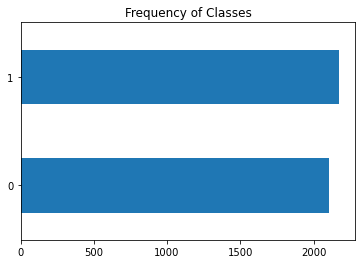

In [9]:
df["labels"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

Yet, the distribution is still about equal so there isn't a big class imbalance.

In [10]:
df["labels"].value_counts(ascending=True)

0    2103
1    2177
Name: labels, dtype: int64

In [11]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)

We also see that the number of words per example in the dataset can be upwards of over 25,000. That is way too many words for the Longformer (max 4098 tokens); therefore, we know that absolutely have to truncate our dataset when training. 

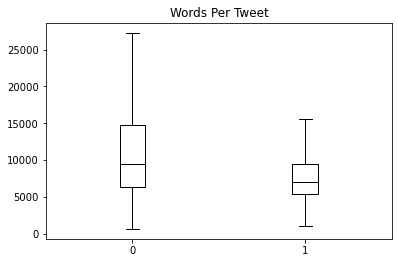

In [12]:
df.boxplot("Words Per Tweet", by="labels", grid=False,
          showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

Now that we are done with our exploratory data analysis, we want to convert the dataset from pandas back to the huggingface dataset format.

In [13]:
cogs402_ds.reset_format()

## Preprocessing

Since the target column is already labeled "labels", we just have to tokenize the text in the dataset. We set truncation to true as we know that many, if not all, examples in our dataset will be over the max amount of tokens our longformer can handle

In [14]:
#trainer API auto uses dynamic padding... supposedly
def tokenize(examples):
    return tokenizer(examples["text"], truncation=True)

In [15]:
#tokenize the data
train_dataset = train_ds.map(tokenize, load_from_cache_file=False)
val_dataset = eval_ds.map(tokenize, load_from_cache_file=False)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

Finally we convert the columns into a pytorch compatible format and remove the text column since the model operates using input ids rather than raw text.

In [16]:
#convert required columns and remove unrequired ones
train_dataset.set_format("torch", columns=['input_ids', 'attention_mask', "labels"])
val_dataset.set_format("torch", columns=['input_ids', 'attention_mask', "labels"])

train_dataset = train_dataset.remove_columns(['text'])
val_dataset = val_dataset.remove_columns(['text'])

In [17]:
print(val_dataset)

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1070
})


## Training

We train 2 epochs and use gradient accumulation, gradient checkpointing and mixed precision in order to lower the memory requirements of the training. These methods, simply put, help your model reduce the amount of memory required to train the model. Given that each example may have up to 4098 tokens, the training uses a lot of memory, so we try to minimize the amount needed. This may have an impact on our training speed, so adjust the parameters based on your GPU.

In [18]:
#create a local models folder for checkpoint storage
if not os.path.exists("models"):
    os.mkdir("models")

Here we set the parameters for our training. Most of these are default parameters, shown for demonstration purposes. We train for 2 epochs and after every epoch, we do a quick checkup on the performance. We set mixed precision (fp16), gradient accumulation and gradient checkpointing to true for memory saving purposes.

In [19]:
from transformers import Trainer, TrainingArguments

batch_size = 1
gradient_acc = 4
logging_steps = (len(train_dataset) // batch_size) //gradient_acc
model_name = f"bert-finetuned_papers"
training_args = TrainingArguments(output_dir=f"models/{model_name}",
                                  num_train_epochs = 2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  fp16=True,
                                  gradient_accumulation_steps=gradient_acc,
                                  gradient_checkpointing=True,
                                  save_strategy = "epoch",
                                  report_to="none")

When passing in more than one example, you need to make sure both examples are the same length, so we pad to the longest example.

In [20]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Make sure you're using connecting to your GPU if you have one

In [21]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

We use f1-score and accuracy as fairly general metrics.

In [22]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

The training arguments are to define the hyperparameters of your fine-tuning but here we are passing in the parameters we want to train.

In [23]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator = data_collator
)

In [24]:
import wandb
wandb.finish()

Here we do the actual training.

In [25]:
trainer.train()

C:\Users\danie\miniconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.277200,0.165630,0.962617,0.962617
2,0.121300,0.146768,0.973832,0.973825


TrainOutput(global_step=2140, training_loss=0.19925993446991822, metrics={'train_runtime': 614.2241, 'train_samples_per_second': 13.936, 'train_steps_per_second': 3.484, 'total_flos': 2252230633881600.0, 'train_loss': 0.19925993446991822, 'epoch': 2.0})

In [26]:
preds_output = trainer.predict(val_dataset)

## Results

Overall the model does very well at predicting whether an example is a Programming Language (P.L.) related paper or Artificial Intelligence (A.I.) related paper. Our accuracy and f1 score is 0.98, which is very high.

In [27]:
preds_output.metrics

{'test_loss': 0.1467684507369995,
 'test_accuracy': 0.9738317757009346,
 'test_f1': 0.9738249134043527,
 'test_runtime': 18.1536,
 'test_samples_per_second': 58.942,
 'test_steps_per_second': 58.942}

In [28]:
import numpy as np
y_preds = np.argmax(preds_output.predictions, axis=1)
y_true = np.array(val_dataset["labels"])

The classification report tells us how the model does in terms of recall, precision, f1-score and accuracy for both classes. We can see that precision is higher for PL papers while recall is higher for AI papers

In [29]:
from sklearn.metrics import classification_report
print(
    classification_report(
        y_true, y_preds, target_names=["PL", "AI"]
    )
)

              precision    recall  f1-score   support

          PL       0.98      0.96      0.97       525
          AI       0.97      0.98      0.97       545

    accuracy                           0.97      1070
   macro avg       0.97      0.97      0.97      1070
weighted avg       0.97      0.97      0.97      1070



By looking at the confusion matrix, we can see how many examples were properly predicted, and how many were false positives (predicted AI instead of PL) or false negatives (predicted PL instead of AI). We use sklearn's confusion matrix function.

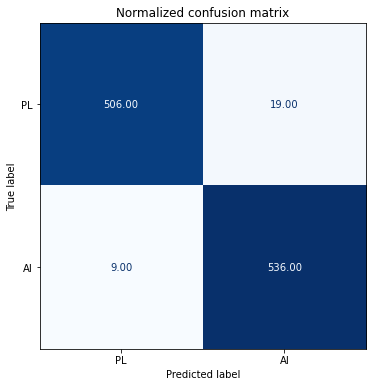

(1070,)
(1070,)


In [30]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["PL", "AI"])
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_true, labels=[0,1])
print(y_true.shape)
print(y_preds.shape)

There are more instance of wrongly predicting AI compared to wrongly predicting PL.

## Publish to Hub

Now that we are done fine-tuning the model and are satisfied with the chosen hyperparameters, we can upload this model to huggingface so we can easily access it in other notebooks/projects. Using the `push_to_hub` function, we pass in our username/name-we-want to create a new repository for your model. If you are wanting to save over a previous model, you can pass in that original repository's name like so: username/original-project. 

More information about authentication tokens can be found on [here](https://huggingface.co/course/chapter4/3?fw=pt#using-the-pushtohub-api) on the huggingface website, which gives a brief summary of how to properly connect to your huggingface account.

In [33]:
# upload model to huggingface for storage
# replace danielhou13 with personal user
from huggingface_hub import notebook_login
notebook_login()


In [35]:
model.push_to_hub('danielhou13/bert-finetuned_papers')

C:\Users\danie\miniconda3\lib\site-packages\huggingface_hub\hf_api.py:1001: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  warnings.warn(
Cloning https://huggingface.co/danielhou13/bert-finetuned_papers into local empty directory.


Upload file pytorch_model.bin:   0%|          | 32.0k/413M [00:00<?, ?B/s]

To https://huggingface.co/danielhou13/bert-finetuned_papers
   40c2374..a6b85c9  main -> main



'https://huggingface.co/danielhou13/bert-finetuned_papers/commit/a6b85c9c5fe16f042d2abcc194e2974ff5f0a747'

Now you can easily access both the model and the dataset used to fine-tune the model for any other tasks you wish using the import functions described in the import section.